In [1]:
#importing the essential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import interpolate, signal, ndimage
from scipy import stats
data_path = './data/'
fig_path = './fig/' 

## Parameter


Measurement Range for Current: 200nA

Vp-p: 10 V

Error(IE) ~ 0.3V


Experiment A
------------------
T: 134.7 C

I_heating: 2.7 A

IE: 15.2 V

V_retared: 1.5 V

Experiment B
------------------

T: 144.5 C 

I_heating: 3 A

IE: 16.0 V

V_retared: 1.5 V

Experiment C
------------------

T: 176.7 C

I_heating: 3.5 A

IE: 25.0 V

V_retared: 1.5 V

Experiment D
------------------

T: 179.7 C

I_heating: 3.5 A

IE: 33.3 V

V_retared: 3.0 V


In [2]:
df_a_unclean = pd.read_csv(data_path + 'A.CSV', skiprows = 15)
df_b_unclean = pd.read_csv(data_path + 'B.CSV', skiprows = 15)
df_c_unclean = pd.read_csv(data_path + 'C.CSV', skiprows = 15)
df_d_unclean = pd.read_csv(data_path + 'D.CSV', skiprows = 15)
df_a_unclean

,TIME,CH1,CH1 Peak Detect,CH2,CH2 Peak Detect
0,-10.000,-0.004,-0.012,-5.6,-5.8
1,-9.996,-0.004,-0.000,-5.6,-5.4
2,-9.992,-0.004,-0.012,-5.6,-5.8
3,-9.988,-0.004,-0.000,-5.6,-5.4
4,-9.985,-0.004,-0.012,-5.6,-5.8
...,...,...,...,...,...
5195,9.950,-0.908,-0.908,-5.6,-5.4
5196,9.954,-0.908,-0.908,-5.6,-5.8
5197,9.958,-0.908,-0.908,-5.6,-5.4
5198,9.962,-0.908,-0.908,-5.6,-5.8


### Clean data

In [3]:
def clean(df, V_ret, T, IE, threshold = 1e-3, trim = 'right'): 
    df = df[['CH1', 'CH2']]
    df = df.rename(columns={'CH1': 'I(nA)', 'CH2': 'V_acc(V)'})
    df['I(nA)'] = - df['I(nA)']/2 * 200
    df['V_acc(V)'] = - df['V_acc(V)']
    df['V_retarded(V)'] = V_ret
    df['T(K)'] = (T + 273.15) 
    df['T(eV)'] = (T + 273.15) * 1.38e-23 / 1.602e-19
    df['IE(eV)'] = IE
    if trim == 'right' :
        for i in range(len(df)):
            if df.loc[i, 'V_acc(V)'] > df.loc[i+1, 'V_acc(V)']:
                df = df.drop(np.arange(i, len(df)))
                break
    elif trim == 'left':
        print(df)
        for i in range(len(df) -1 , -1, -1):
            if df.loc[i - 1, 'V_acc(V)'] > df.loc[i, 'V_acc(V)']:
                df = df.drop(np.arange(i+1)).reset_index()
                break
    return df
df_a_unsmooth = clean(df_a_unclean, 1.5, 134.7, 15.2)
df_b_unsmooth = clean(df_b_unclean, 1.5, 144.5, 16.0)
df_c_unsmooth = clean(df_c_unclean, 1.5, 176.7, 25.0, trim = None)
df_d_unsmooth = clean(df_d_unclean, 3.0, 179.7, 33.3, trim = None)
df_c_unsmooth = df_c_unsmooth[df_c_unsmooth['V_acc(V)'] > 10].reset_index()
df_c_unsmooth = df_c_unsmooth[df_c_unsmooth['V_acc(V)'] < 27].reset_index()
df_a_unsmooth.head()

,I(nA),V_acc(V),V_retarded(V),T(K),T(eV),IE(eV)
0,0.4,5.6,1.5,407.85,0.035133,15.2
1,0.4,5.6,1.5,407.85,0.035133,15.2
2,0.4,5.6,1.5,407.85,0.035133,15.2
3,0.4,5.6,1.5,407.85,0.035133,15.2
4,0.4,5.6,1.5,407.85,0.035133,15.2


[10.58845901 15.23245313]


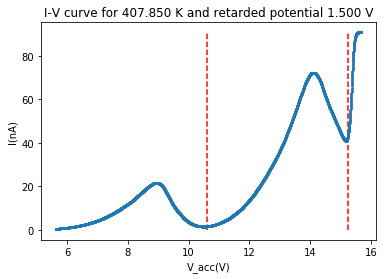

In [4]:
# smoothen the function
df_a = df_a_unsmooth.copy()
df_a['V_acc(V)'] = ndimage.gaussian_filter(df_a_unsmooth['V_acc(V)'].values, sigma = 40)
df_a['I(nA)'] = ndimage.gaussian_filter(df_a_unsmooth['I(nA)'].values, sigma = 40)
plt.plot(df_a['V_acc(V)'], df_a['I(nA)'], '.', markersize = 3)
plt.xlabel('V_acc(V)')
plt.ylabel('I(nA)')
plt.title('I-V curve for {:.3f} K and retarded potential {:.3f} V'.format(
    df_a.loc[0, 'T(K)']
    ,df_a.loc[0, 'V_retarded(V)']))
# plt.savefig(fig_path + 'A.png', dpi = 300)
widths = np.linspace(500, 1000, num = 100)
peakA = signal.find_peaks_cwt(1/df_a['I(nA)'].values, widths)
plt.vlines(df_a['V_acc(V)'].values[peakA][1:], 0, df_a['I(nA)'].max(), 'r', linestyle = '--')
print(df_a['V_acc(V)'].values[peakA][1:])
A_crit = df_a['V_acc(V)'].values[peakA][1:]


[10.50402735 15.70265131]


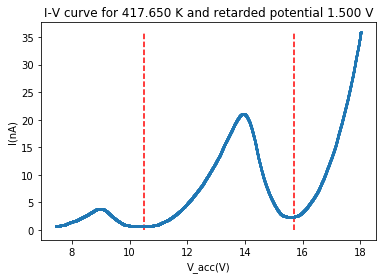

In [5]:
# smoothen the function
df_b = df_b_unsmooth.copy()
df_b['V_acc(V)'] = ndimage.gaussian_filter(df_b_unsmooth['V_acc(V)'].values, sigma = 40)
df_b['I(nA)'] = ndimage.gaussian_filter(df_b_unsmooth['I(nA)'].values, sigma = 60)
plt.plot(df_b['V_acc(V)'], df_b['I(nA)'], '.', markersize = 3)
plt.xlabel('V_acc(V)')
plt.ylabel('I(nA)')
plt.title('I-V curve for {:.3f} K and retarded potential {:.3f} V'.format(
    df_b.loc[0, 'T(K)']
    ,df_b.loc[0, 'V_retarded(V)']))
# plt.savefig(fig_path + 'B.png', dpi = 300)
widths = np.linspace(500, 1000, num = 100)
peakb = signal.find_peaks_cwt(1/df_b['I(nA)'].values, widths)
plt.vlines(df_b['V_acc(V)'].values[peakb], 0, df_b['I(nA)'].max(), 'r', linestyle = '--')
print(df_b['V_acc(V)'].values[peakb])
B_crit = df_b['V_acc(V)'].values[peakb]

[10.68132322 15.7314791  20.39663206 25.27971297]


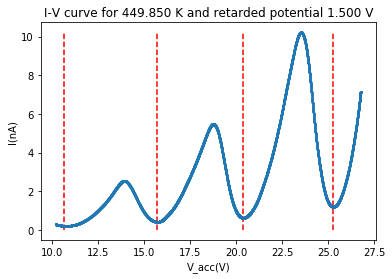

In [6]:
df_c = df_c_unsmooth.copy()
df_c['V_acc(V)'] = ndimage.gaussian_filter(df_c_unsmooth['V_acc(V)'].values, sigma = 40)
df_c['I(nA)'] = ndimage.gaussian_filter(df_c_unsmooth['I(nA)'].values, sigma = 40)
plt.plot(df_c['V_acc(V)'], df_c['I(nA)'], '.', markersize = 3)
plt.xlabel('V_acc(V)')
plt.ylabel('I(nA)')
plt.title('I-V curve for {:.3f} K and retarded potential {:.3f} V'.format(
    df_c.loc[0, 'T(K)']
    ,df_c.loc[0, 'V_retarded(V)']))
# plt.savefig(fig_path + 'C.png', dpi = 300)
# plt.plot(df_c['V_acc(V)'])
widths = np.linspace(100, 1400, num = 100)
peakc = signal.find_peaks_cwt(1/df_c['I(nA)'].values, widths)
plt.vlines(df_c['V_acc(V)'].values[peakc], 0, df_c['I(nA)'].max(), 'r', linestyle = '--')
print(df_c['V_acc(V)'].values[peakc])
C_crit = df_c['V_acc(V)'].values[peakc]

[ 9.10086271 14.75551445 19.54839877 24.45183503]


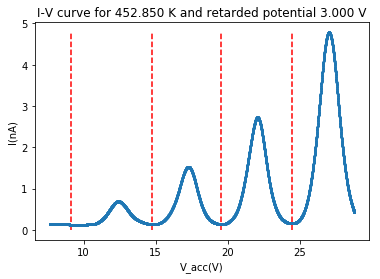

In [7]:
df_d_unsmooth = df_d_unsmooth.loc[:5000]
df_d = df_d_unsmooth.copy()
df_d['V_acc(V)'] = ndimage.gaussian_filter(df_d_unsmooth['V_acc(V)'].values, sigma = 50)
df_d['I(nA)'] = ndimage.gaussian_filter(df_d_unsmooth['I(nA)'].values, sigma = 50)
plt.plot(df_d['V_acc(V)'], df_d['I(nA)'], '.', markersize = 3)
plt.xlabel('V_acc(V)')
plt.ylabel('I(nA)')
plt.title('I-V curve for {:.3f} K and retarded potential {:.3f} V'.format(
    df_d.loc[0, 'T(K)']
    ,df_d.loc[0, 'V_retarded(V)']))
# plt.savefig(fig_path + 'D.png', dpi = 300)
widths = np.linspace(100, 1400, num = 100)
peakd = signal.find_peaks_cwt(1/df_d['I(nA)'].values, widths)
plt.vlines(df_d['V_acc(V)'].values[peakd], 0, df_d['I(nA)'].max(), 'r', linestyle = '--')
print(df_d['V_acc(V)'].values[peakd])
D_crit = df_d['V_acc(V)'].values[peakd]

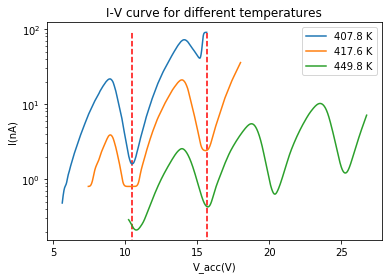

In [8]:
plt.xlabel('V_acc(V)')
plt.ylabel('I(nA)')
plt.title('I-V curve for different temperatures')
plt.plot(df_a['V_acc(V)'], df_a['I(nA)'], markersize = 3, label = '{:.1f} K'.format(df_a.loc[0, 'T(K)']))
plt.plot(df_b['V_acc(V)'], df_b['I(nA)'], markersize = 3, label = '{:.1f} K'.format(df_b.loc[0, 'T(K)']))
plt.plot(df_c['V_acc(V)'], df_c['I(nA)'], markersize = 3, label = '{:.1f} K'.format(df_c.loc[0, 'T(K)']))
# plt.plot(df_d['V_acc(V)'], df_d['I(nA)'], markersize = 3, label = 'D')
plt.legend()
plt.yscale('log')
# plt.vlines(df_c['V_acc(V)'].values[peakc], 0, df_a['I(nA)'].max(), 'r', linestyle = '--')
plt.vlines(df_b['V_acc(V)'].values[peakb], 0, df_a['I(nA)'].max(), 'r', linestyle = '--')
# plt.vlines(df_a['V_acc(V)'].values[peakA], 0, df_a['I(nA)'].max(), 'r', linestyle = '--')
plt.savefig(fig_path + 'Temp.png', dpi = 300)

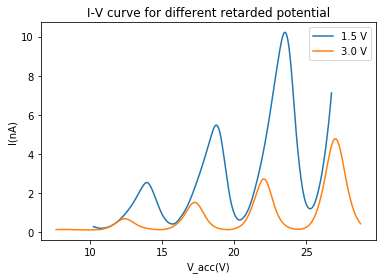

In [9]:
plt.xlabel('V_acc(V)')
plt.ylabel('I(nA)')
plt.title('I-V curve for different retarded potential')
plt.plot(df_c['V_acc(V)'], df_c['I(nA)'], markersize = 3, label = '1.5 V')
plt.plot(df_d['V_acc(V)'], df_d['I(nA)'], markersize = 3, label = '3.0 V')
plt.legend()

# plt.savefig(fig_path + 'Retarded.png', dpi = 300)

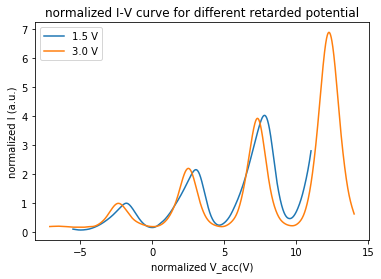

In [10]:
plt.xlabel('normalized V_acc(V)')
plt.ylabel('normalized I (a.u.)')
plt.title('normalized I-V curve for different retarded potential')
peakc_1 = signal.find_peaks_cwt(df_c['I(nA)'], np.linspace(100, 400, 100))
peakc_1 = peakc_1[:-1]
# plt.vlines(df_c.loc[peakc_1, 'V_acc(V)'], 0, 5, 'r', linestyle = '--')
peakd_1 = signal.find_peaks_cwt(df_d['I(nA)'], np.linspace(100, 400, 100))
peakd_1 = peakd_1[1:]
# plt.vlines(df_d.loc[peakd_1, 'V_acc(V)'], 0, 5, 'r', linestyle = '--')
norm_C = df_c['I(nA)']/df_c.loc[peakc_1[0], 'I(nA)']
norm_D = df_d['I(nA)']/df_d.loc[peakd_1[0], 'I(nA)']
norm_c_x = df_c['V_acc(V)'] - df_c.loc[peakc[1],'V_acc(V)']
norm_d_x = df_d['V_acc(V)'] - df_d.loc[peakd[1],'V_acc(V)']
plt.plot(norm_c_x, norm_C, markersize = 3, label = '1.5 V')
plt.plot(norm_d_x, norm_D, markersize = 3, label = '3.0 V')
plt.legend()
# widthc = signal.peak_widths(norm_C, peakc_1, rel_height = 0.5) 
# widthd = signal.peak_widths(df_d['I(nA)'].values, peakd_1, rel_height = 0.5) 
# print('widthc:', widthc[0])
# print('widthd:', widthd[0])
# plt.plot(df_c['V_acc(V)'].values[peakc_1], norm_C.values[peakc_1], 'x')

# plt.savefig(fig_path + 'Retarded_norm2.png', dpi = 300)

[10.58845901 15.23245313]
[10.50402735 15.70265131]
[10.68132322 15.7314791  20.39663206 25.27971297]
[ 9.10086271 14.75551445 19.54839877 24.45183503]
A: 4.643994118911266 5.944464894479486 0.0 0.0
B: 5.198623962115446 5.305403390471279 0.0 0.0
C: 4.8460322204058555 5.907206286479411 0.022429798876984607 0.06142653402614256
D: 5.084580127563 4.252702422312121 0.061376123081690465 0.1680854355202768
4.897781051379988 5.719030167609757 0.021702828879249757 0.04852900067804803
shifted: 1.4663277452976367 0.17495078605382464


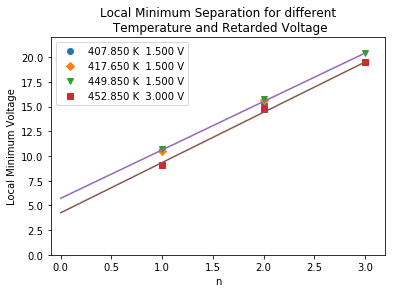

In [17]:
print(A_crit)
print(B_crit)
print(C_crit)
print(D_crit)
x_a = np.arange(len(A_crit))+ 1
x_b = np.arange(len(B_crit))+1
x_c = np.arange(len(C_crit))+1
x_d = np.arange(len(D_crit))+1
plt.plot(x_a, A_crit, 'o', label = '{:.3f} K  {:.3f} V'.format(
    df_a.loc[0, 'T(K)']
    ,df_a.loc[0, 'V_retarded(V)']))
plt.plot(x_b, B_crit, 'D', label = '{:.3f} K  {:.3f} V'.format(
    df_b.loc[0, 'T(K)']
    ,df_b.loc[0, 'V_retarded(V)']))
plt.plot(x_c , C_crit, 'v', label = '{:.3f} K  {:.3f} V'.format(
    df_c.loc[0, 'T(K)']
    ,df_c.loc[0, 'V_retarded(V)']))
plt.plot(x_d, D_crit, 's', label = '{:.3f} K  {:.3f} V'.format(
    df_d.loc[0, 'T(K)']
    ,df_d.loc[0, 'V_retarded(V)']))
plt.legend()
plt.xlim([-0.1,3.2])
plt.ylim([0,22])
def linregress(x, y):
    slope, intercept, r, prob2, see = stats.linregress(x, y)
    mx = x.mean()
    sx2 = ((x-mx)**2).sum()
    sd_intercept = see * (1./len(x) + mx*mx/sx2)**0.5
    sd_slope = see * (1./sx2)**0.5
    return slope, intercept, sd_slope, sd_intercept, r**2

Aslope, Acept, Aserr, Acerr, _ = linregress(x_a,A_crit)
Bslope, Bcept, Bserr, Bcerr, _ = linregress(x_b,B_crit)
Cslope, Ccept, Cserr, Ccerr, _ = linregress(x_c,C_crit)
Dslope, Dcept, Dserr, Dcerr, _ = linregress(x_d,D_crit)
print("A:", Aslope, Acept, Aserr, Acerr)
print("B:", Bslope, Bcept, Bserr, Bcerr)
print("C:", Cslope, Ccept, Cserr, Ccerr)
print("D:", Dslope, Dcept, Dserr, Dcerr)

x_all = np.hstack((x_a, x_b, x_c))
y_all = np.hstack((A_crit, B_crit, C_crit))
slope, intercept, eslope, ecept, _ = linregress(x_all, y_all)
print(slope, intercept, eslope, ecept)
plt.plot(np.linspace(0, 3, 100), slope * np.linspace(0, 3, 100) + intercept)
plt.plot(np.linspace(0, 3, 100), Dslope * np.linspace(0, 3, 100) + Dcept)
print('shifted:', intercept - Dcept, (ecept **2 + Dcerr**2)**0.5)
plt.xlabel('n')
plt.ylabel('Local Minimum Voltage')
plt.title('Local Minimum Separation for different\n Temperature and Retarded Voltage')
# plt.savefig(fig_path + 'local_min.png', dpi = 300)

[407.84999999999997, 417.65, 449.84999999999997]
[15.2, 16.0, 25.0]


Text(0.5,1,'Critical Volatage as a Function of Temperature \nfor 1.5V Retarded Potential')

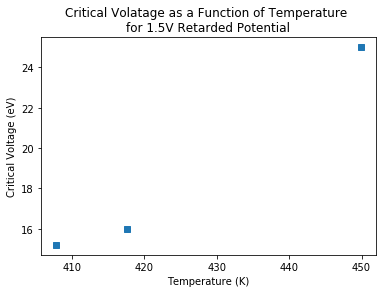

In [12]:
Ta = df_a.loc[0, 'T(K)']
Tb = df_b.loc[0, 'T(K)']
Tc = df_c.loc[0, 'T(K)' ]
Td = df_d.loc[0, 'T(K)']
T = [Ta, Tb, Tc]
print(T)
IEa = df_a.loc[0, 'IE(eV)']
IEb = df_b.loc[0, 'IE(eV)']
IEc = df_c.loc[0, 'IE(eV)' ]
IEd = df_d.loc[0, 'IE(eV)']
IE = [IEa, IEb, IEc]
print(IE)

plt.plot(T, IE, 's')
plt.xlabel('Temperature (K)')
plt.ylabel('Critical Voltage (eV)')
plt.title('Critical Volatage as a Function of Temperature \nfor 1.5V Retarded Potential')
# plt.savefig('critical.png', dpi = 300)



## Toy Model

In [13]:
V_retarded = 1.5
V_acc = np.linspace(0, 30, 100)
#counting the end particle
count = lambda V: np.sum(V > 0, axis = 0)
E_field = lambda V, V_acc: V + V_acc

def no_collision(V_acc):
    V = np.zeros((1000, len(V_acc)))
    V = E_field(V, V_acc)
    V = E_field(V, -V_retarded)
    return count(V)

def mfp(V_acc, lamda = 0.01):
    V = np.zeros((1000, len(V_acc)))
    for i in range(len(V_acc) - 1):
#         print(V_acc[i])
        V[i+1] =  V[i] + V_acc[i+1] - V_acc[i]# - lamda * V[i]
#         print(V[i+1])
#     V = E_field(V, -V_retarded)
    return count(V)
    
    

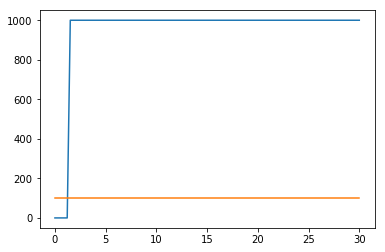

In [14]:
plt.plot(V_acc, no_collision(V_acc))
plt.plot(V_acc, mfp(V_acc))